# Model Results Analysis

This notebook analyzes the results from different model configurations trained for chess game outcome prediction.

## Overview
- Models are organized by whether they include `victory_status` as a feature
- Each model configuration varies by:
  - **Duration**: Whether to use duration dataset (`duration`) or not (`noduration`)
  - **Turns**: Whether to include turns feature (`withturn`) or not (`noturn`)
  - **Moves**: Number of moves to include (1-7, or None for all moves)
  - **Victory Status**: Whether to include victory_status feature (separate folder structure)

In [16]:
import json
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Optional
import warnings
warnings.filterwarnings('ignore')

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Results directory
RESULTS_DIR = Path("results")


In [17]:
def load_model_results(results_dir: Path) -> pd.DataFrame:
    """
    Load all model results from the results directory.
    
    Returns a DataFrame with all model configurations and their metrics.
    """
    results = []
    
    # Process both folders: models_with_victory_status and models_without_victory_status
    for folder_name in ["models_with_victory_status", "models_without_victory_status"]:
        folder_path = results_dir / folder_name
        if not folder_path.exists():
            print(f"Warning: {folder_path} does not exist")
            continue
            
        # Determine if victory_status is included based on folder name
        has_victory_status = folder_name == "models_with_victory_status"
        
        # Try to load multi_study_results.json first (if available)
        multi_results_path = folder_path / "multi_study_results.json"
        if multi_results_path.exists():
            with open(multi_results_path, 'r', encoding='utf-8') as f:
                multi_results = json.load(f)
                for result in multi_results:
                    if "error" not in result:
                        results.append({
                            "has_victory_status": has_victory_status,
                            "use_duration": result.get("use_duration", None),
                            "use_turns": result.get("use_turns", None),
                            "moves_n": result.get("moves_n", None),
                            "moves_only_n": result.get("moves_only_n", None),
                            "best_accuracy": result.get("best_accuracy", None),
                            "best_f1_macro": result.get("best_f1_macro", None),
                            "n_estimators": result.get("best_params", {}).get("n_estimators", None),
                            "max_depth": result.get("best_params", {}).get("max_depth", None),
                            "learning_rate": result.get("best_params", {}).get("learning_rate", None),
                            "config_name": result.get("config_name", ""),
                            "source": "multi_study_results.json"
                        })
        
        # Also load individual model directories
        for model_dir in folder_path.iterdir():
            if not model_dir.is_dir() or model_dir.name.startswith("."):
                continue
                
            metrics_path = model_dir / "metrics.json"
            params_path = model_dir / "best_params.json"
            
            if metrics_path.exists() and params_path.exists():
                try:
                    with open(metrics_path, 'r', encoding='utf-8') as f:
                        metrics = json.load(f)
                    with open(params_path, 'r', encoding='utf-8') as f:
                        params = json.load(f)
                    
                    # Parse directory name to extract configuration
                    # Format: {duration/noduration}-{withturn/noturn}-{moves_n}-{moves_only_n}
                    parts = model_dir.name.split("-")
                    if len(parts) >= 4:
                        use_duration = parts[0] == "duration"
                        use_turns = parts[1] == "withturn"
                        moves_n_str = parts[2]
                        moves_n = None if moves_n_str == "None" else int(moves_n_str)
                        moves_only_n = parts[3] == "True"
                        
                        results.append({
                            "has_victory_status": has_victory_status,
                            "use_duration": use_duration,
                            "use_turns": use_turns,
                            "moves_n": moves_n,
                            "moves_only_n": moves_only_n,
                            "best_accuracy": metrics.get("best_accuracy", None),
                            "best_f1_macro": metrics.get("best_f1_macro", None),
                            "best_train_accuracy": metrics.get("best_train_accuracy", None),
                            "n_estimators": params.get("n_estimators", None),
                            "max_depth": params.get("max_depth", None),
                            "learning_rate": params.get("learning_rate", None),
                            "config_name": model_dir.name,
                            "source": "individual_dir"
                        })
                except Exception as e:
                    print(f"Error loading {model_dir}: {e}")
    
    df = pd.DataFrame(results)
    
    # Remove duplicates (prefer multi_study_results.json)
    if len(df) > 0:
        df = df.sort_values("source").drop_duplicates(
            subset=["has_victory_status", "use_duration", "use_turns", "moves_n", "moves_only_n"],
            keep="first"
        )
    
    return df

# Load all results
df_results = load_model_results(RESULTS_DIR)
print(f"Loaded {len(df_results)} model configurations")
df_results.head()


Error loading results\models_without_victory_status\duration-noturn-novstatus-1-True: invalid literal for int() with base 10: 'novstatus'
Error loading results\models_without_victory_status\duration-noturn-novstatus-2-True: invalid literal for int() with base 10: 'novstatus'
Error loading results\models_without_victory_status\duration-noturn-novstatus-3-True: invalid literal for int() with base 10: 'novstatus'
Error loading results\models_without_victory_status\duration-noturn-novstatus-4-True: invalid literal for int() with base 10: 'novstatus'
Error loading results\models_without_victory_status\duration-noturn-novstatus-5-True: invalid literal for int() with base 10: 'novstatus'
Error loading results\models_without_victory_status\duration-noturn-novstatus-6-True: invalid literal for int() with base 10: 'novstatus'
Error loading results\models_without_victory_status\duration-noturn-novstatus-7-True: invalid literal for int() with base 10: 'novstatus'
Error loading results\models_witho

,has_victory_status,use_duration,use_turns,moves_n,moves_only_n,best_accuracy,best_f1_macro,n_estimators,max_depth,learning_rate,config_name,source,best_train_accuracy
47,True,True,True,NaN,True,0.850932,0.887238,350,8,0.175253,duration-withturn-None-True,individual_dir,0.996983
33,True,True,False,2.0,True,0.650932,0.745840,100,8,0.013445,duration-noturn-2-True,individual_dir,0.733937
34,True,True,False,3.0,True,0.650518,0.746015,100,4,0.042344,duration-noturn-3-True,individual_dir,0.696131
35,True,True,False,4.0,True,0.649689,0.745805,400,3,0.026466,duration-noturn-4-True,individual_dir,0.702343
36,True,True,False,5.0,True,0.649275,0.745445,400,4,0.018539,duration-noturn-5-True,individual_dir,0.706958


In [18]:
# Display basic statistics
print("=" * 80)
print("DATASET OVERVIEW")
print("=" * 80)
print(f"\nTotal configurations: {len(df_results)}")
print(f"\nBreakdown by victory_status:")
print(df_results['has_victory_status'].value_counts())
print(f"\nBreakdown by duration:")
print(df_results['use_duration'].value_counts())
print(f"\nBreakdown by turns:")
print(df_results['use_turns'].value_counts())
print(f"\nBreakdown by moves_n:")
print(df_results['moves_n'].value_counts().sort_index())

print(f"\n\nMetrics Summary:")
print(df_results[['best_accuracy']].describe())


DATASET OVERVIEW

Total configurations: 64

Breakdown by victory_status:
has_victory_status
True     32
False    32
Name: count, dtype: int64

Breakdown by duration:
use_duration
True     32
False    32
Name: count, dtype: int64

Breakdown by turns:
use_turns
True     32
False    32
Name: count, dtype: int64

Breakdown by moves_n:
moves_n
1.0    8
2.0    8
3.0    8
4.0    8
5.0    8
6.0    8
7.0    8
Name: count, dtype: int64


Metrics Summary:
       best_accuracy
count      64.000000
mean        0.743898
std         0.109321
min         0.590890
25%         0.644372
50%         0.741133
75%         0.840907
max         0.889667


## Top Performing Models


In [19]:
# Top 10 models by accuracy
print("=" * 80)
print("TOP 10 MODELS BY ACCURACY")
print("=" * 80)
top_accuracy = df_results.nlargest(10, 'best_accuracy')[
    ['has_victory_status', 'use_duration', 'use_turns', 'moves_n', 
     'best_accuracy', 'n_estimators', 'max_depth', 'learning_rate']
]
print(top_accuracy.to_string(index=False))


TOP 10 MODELS BY ACCURACY
 has_victory_status  use_duration  use_turns  moves_n  best_accuracy  n_estimators  max_depth  learning_rate
               True         False       True      NaN       0.889667           600          6       0.219410
               True         False       True      3.0       0.887916           350          7       0.296324
               True         False       True      4.0       0.887916           500          5       0.242971
               True         False       True      1.0       0.887478           350          6       0.242330
               True         False       True      6.0       0.887040           450          6       0.204856
               True         False       True      7.0       0.885727           350          6       0.264051
               True         False       True      2.0       0.885508           400          6       0.272123
               True         False       True      5.0       0.885508           400          7       0.

It seems like our best performing models are the one that use the turns number. Does this mean that the number of turns has a high influence on who the winner is? (YES, it's very probable, since for example, if the game ended before the turn of black, it is most likeley that he lost by checkmate or he resigned before playing his next turn)

## Impact of Different Features


Impact of Victory Status Feature:
                        mean       std       min       max
has_victory_status                                        
False               0.718476  0.104947  0.590890  0.837566
True                0.769321  0.109269  0.647619  0.889667



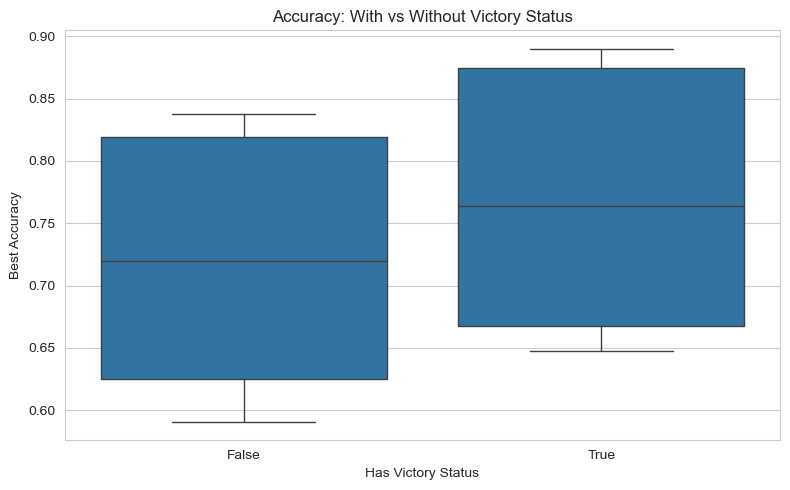

In [21]:
# Compare models with and without victory_status
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

# Accuracy comparison
victory_status_comparison = df_results.groupby('has_victory_status')['best_accuracy'].agg(['mean', 'std', 'min', 'max'])
print("=" * 80)
print("Impact of Victory Status Feature:")
print("=" * 80)
print(victory_status_comparison)
print()

sns.boxplot(data=df_results, x='has_victory_status', y='best_accuracy', ax=ax)
ax.set_title('Accuracy: With vs Without Victory Status')
ax.set_xlabel('Has Victory Status')
ax.set_ylabel('Best Accuracy')

plt.tight_layout()
plt.show()


Victory status (resigned, outoftime etc...) seems to have a influence in the accuracy. Models that used this feature had a better accuracy rate.

Impact of Duration Feature:
                  mean       std       min       max
use_duration                                        
False         0.757026  0.107427  0.631786  0.889667
True          0.730771  0.111318  0.590890  0.870393



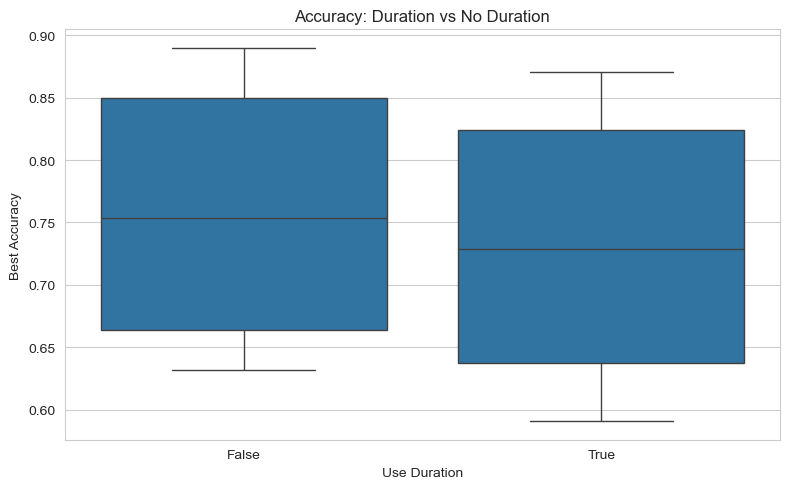

In [23]:
# Compare duration vs noduration
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

duration_comparison = df_results.groupby('use_duration')['best_accuracy'].agg(['mean', 'std', 'min', 'max'])
print("=" * 80)
print("Impact of Duration Feature:")
print("=" * 80)
print(duration_comparison)
print()

sns.boxplot(data=df_results, x='use_duration', y='best_accuracy', ax=ax)
ax.set_title('Accuracy: Duration vs No Duration')
ax.set_xlabel('Use Duration')
ax.set_ylabel('Best Accuracy')

plt.tight_layout()
plt.show()


Duration seems to have been a interesting features for the different models, has models that used it did have a somewhat better results than those that didn't

Impact of Turns Feature:
               mean       std       min       max
use_turns                                        
False      0.639377  0.028067  0.590890  0.676883
True       0.848420  0.030751  0.805383  0.889667



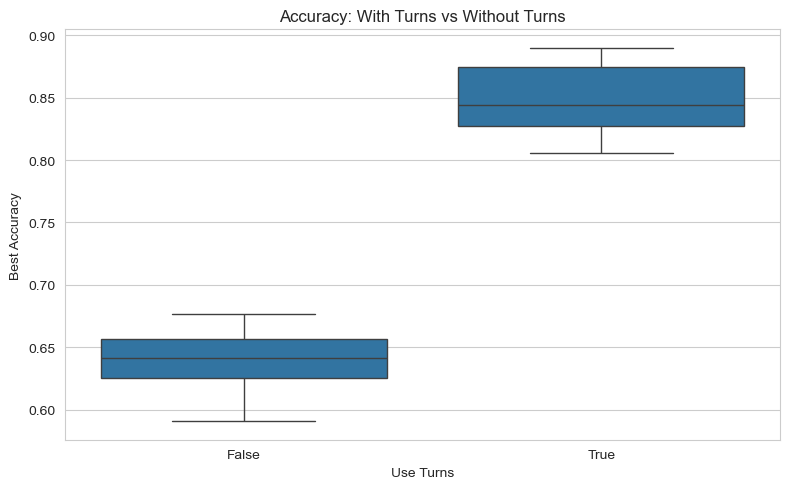

In [24]:
# Compare with turns vs without turns
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

turns_comparison = df_results.groupby('use_turns')['best_accuracy'].agg(['mean', 'std', 'min', 'max'])
print("=" * 80)
print("Impact of Turns Feature:")
print("=" * 80)
print(turns_comparison)
print()

sns.boxplot(data=df_results, x='use_turns', y='best_accuracy', ax=ax)
ax.set_title('Accuracy: With Turns vs Without Turns')
ax.set_xlabel('Use Turns')
ax.set_ylabel('Best Accuracy')

plt.tight_layout()
plt.show()


Models using turns have a significantly better accuracy than those that don't. We already seen before that models using turns tend to be the one that performed better. As explained before, turn parity indicates the winner:
- If the game ends on an odd turn (1, 3, 5, ...), it ended during White's turn → White likely won (checkmate) or Black resigned.
- If it ends on an even turn (2, 4, 6, ...), it ended during Black's turn → Black likely won or White resigned.
This gives a strong signal about the outcome

Moreover it can also have interactions with other features:
- Turns combined with victory_status (if available) can be very informative.
- Turns combined with move sequences can help identify patterns

## Impact of Number of Moves


Accuracy by Number of Moves:
                     mean       std
moves_n_display                    
All              0.742563  0.115881
1                0.744691  0.115009
2                0.746155  0.115786
3                0.744070  0.118485
4                0.744153  0.115234
5                0.742895  0.115832
6                0.742713  0.116849
7                0.743948  0.114449



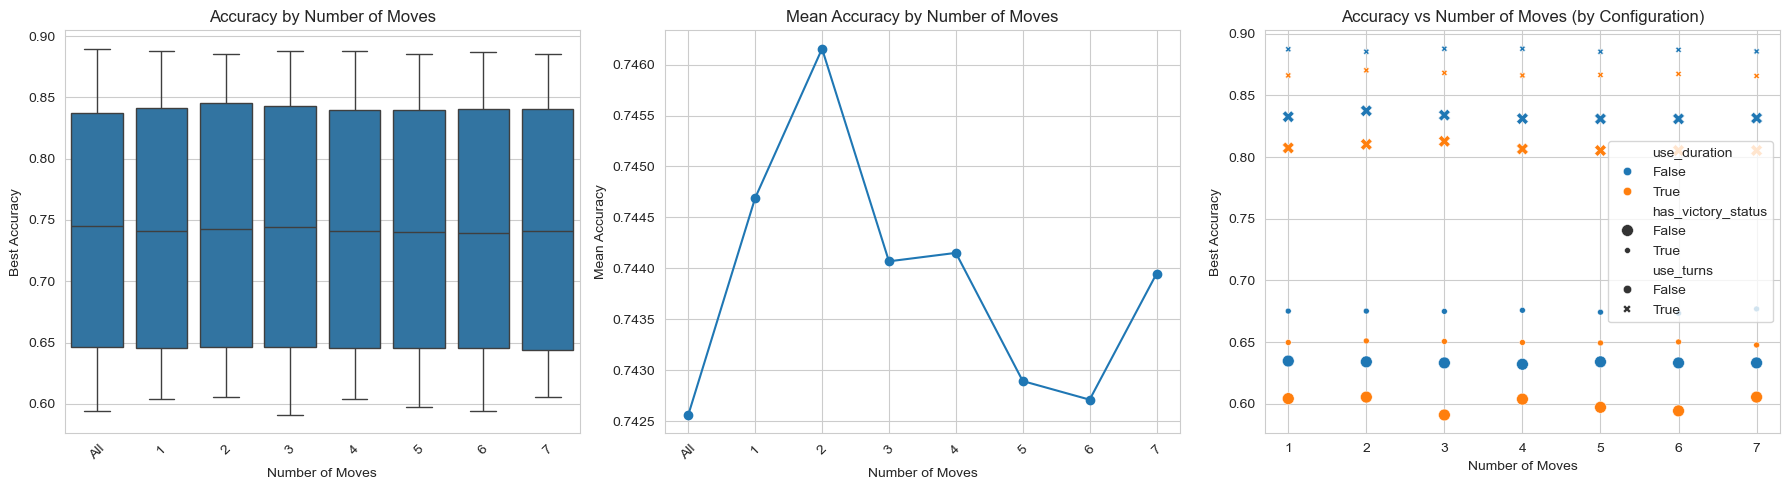

In [33]:
# Analyze impact of number of moves
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Replace None with "All" for better visualization
df_plot = df_results.copy()
df_plot['moves_n_display'] = df_plot['moves_n'].apply(lambda x: 'All' if (x is None or pd.isna(x)) else str(int(x)) if isinstance(x, (int, float)) else str(x))

# Accuracy by moves_n - sort properly
moves_order = ['All', '1', '2', '3', '4', '5', '6', '7']
moves_accuracy = df_plot.groupby('moves_n_display')['best_accuracy'].agg(['mean', 'std'])
moves_accuracy = moves_accuracy.reindex([x for x in moves_order if x in moves_accuracy.index])
print("=" * 80)
print("Accuracy by Number of Moves:")
print("=" * 80)
print(moves_accuracy)
print()

sns.boxplot(data=df_plot, x='moves_n_display', y='best_accuracy', ax=axes[0], order=moves_order)
axes[0].set_title('Accuracy by Number of Moves')
axes[0].set_xlabel('Number of Moves')
axes[0].set_ylabel('Best Accuracy')
axes[0].tick_params(axis='x', rotation=45)

# Line plot showing trend
moves_mean = df_plot.groupby('moves_n_display')['best_accuracy'].mean()
moves_mean = moves_mean.reindex([x for x in moves_order if x in moves_mean.index])
moves_mean.plot(kind='line', ax=axes[1], marker='o')
axes[1].set_title('Mean Accuracy by Number of Moves')
axes[1].set_xlabel('Number of Moves')
axes[1].set_ylabel('Mean Accuracy')
axes[1].tick_params(axis='x', rotation=45)

# Scatter plot: moves_n vs accuracy (colored by other features)
scatter_data = df_plot[df_plot['moves_n'].notna()].copy()
sns.scatterplot(data=scatter_data, x='moves_n', y='best_accuracy', 
                hue='use_duration', style='use_turns', size='has_victory_status', ax=axes[2])
axes[2].set_title('Accuracy vs Number of Moves (by Configuration)')
axes[2].set_xlabel('Number of Moves')
axes[2].set_ylabel('Best Accuracy')

plt.tight_layout()
plt.show()


Accuracy doesn't seems to be impacted by knowing the first few moves of the game. That means that even if we give the model the first few moves that have been made, we didn't manage to predict more accurately that if we didn't.

We can theorize that stronger features might dominate, like turns that encodes the winner via parity (odd/even).

Early moves might also be less informative, the first moves are often standard openings and don’t instantly predict outcome, some moves might have an advantage but we are too early in the game to deduce a winner, critical decisions usually occur later.

## Feature Combination Analysis

Instead of looking at features one at a time, we will create combinations of features (e.g., Duration + Turns + Victory Status) to compare the performance across these combinations and identify which combinations work best together to see if the combinaison of those features are critical for our models or not

Metrics by Feature Combination:
                             best_accuracy              
                                      mean     std count
config_combo                                            
Duration_NoTurns_NoVStatus          0.5994  0.0059     8
Duration_NoTurns_VStatus            0.6499  0.0012     8
Duration_Turns_NoVStatus            0.8085  0.0037     8
Duration_Turns_VStatus              0.8653  0.0060     8
NoDuration_NoTurns_NoVStatus        0.6332  0.0010     8
NoDuration_NoTurns_VStatus          0.6750  0.0010     8
NoDuration_Turns_NoVStatus          0.8328  0.0022     8
NoDuration_Turns_VStatus            0.8871  0.0015     8



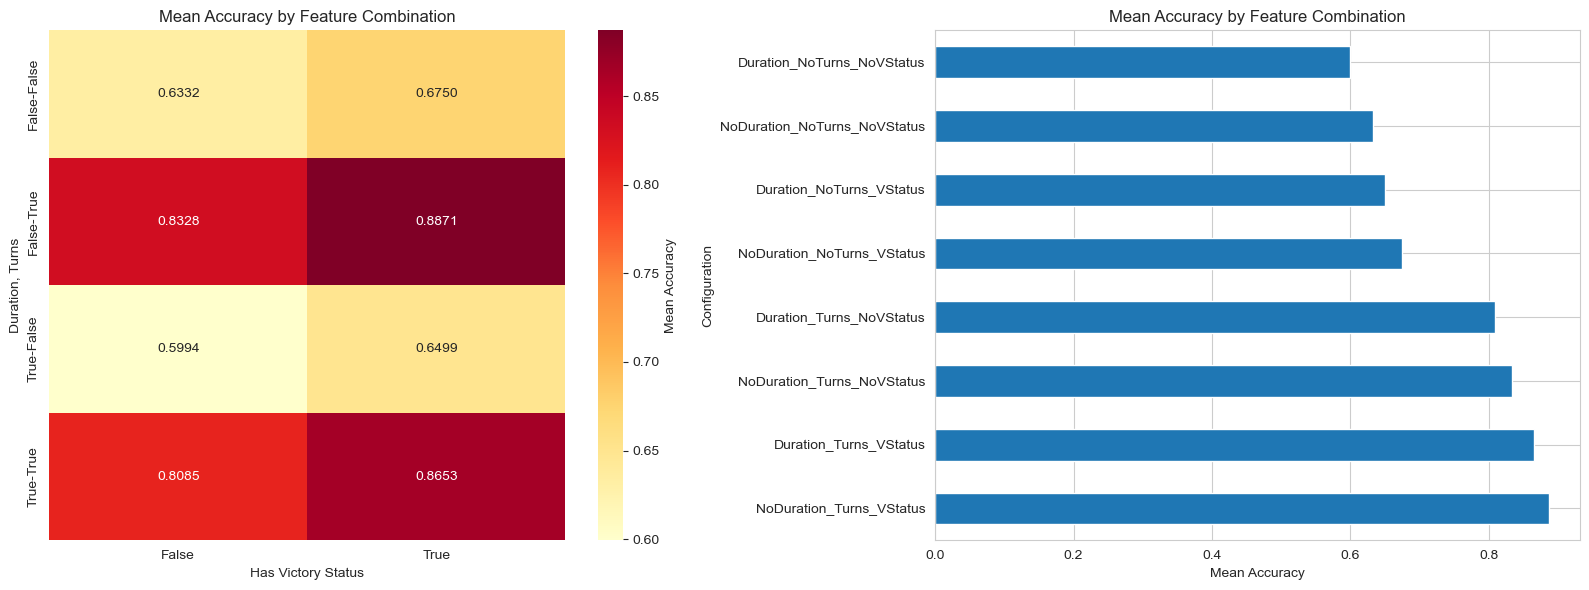

In [29]:
# Create a comprehensive feature combination analysis
df_results['config_combo'] = (
    df_results['use_duration'].map({True: 'Duration', False: 'NoDuration'}) + '_' +
    df_results['use_turns'].map({True: 'Turns', False: 'NoTurns'}) + '_' +
    df_results['has_victory_status'].map({True: 'VStatus', False: 'NoVStatus'})
)

# Heatmap of average accuracy by feature combination
combo_metrics = df_results.groupby('config_combo').agg({
    'best_accuracy': ['mean', 'std', 'count']
}).round(4)

print("=" * 80)
print("Metrics by Feature Combination:")
print("=" * 80)
print(combo_metrics)
print()

# Create pivot table for heatmap
pivot_data = df_results.pivot_table(
    values='best_accuracy',
    index=['use_duration', 'use_turns'],
    columns='has_victory_status',
    aggfunc='mean'
)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Heatmap
sns.heatmap(pivot_data, annot=True, fmt='.4f', cmap='YlOrRd', ax=axes[0], cbar_kws={'label': 'Mean Accuracy'})
axes[0].set_title('Mean Accuracy by Feature Combination')
axes[0].set_xlabel('Has Victory Status')
axes[0].set_ylabel('Duration, Turns')

# Bar plot comparing combinations
combo_mean = df_results.groupby('config_combo')['best_accuracy'].mean().sort_values(ascending=False)
combo_mean.plot(kind='barh', ax=axes[1])
axes[1].set_title('Mean Accuracy by Feature Combination')
axes[1].set_xlabel('Mean Accuracy')
axes[1].set_ylabel('Configuration')

plt.tight_layout()
plt.show()


We can find that turns is the most important feature:
- Without Turns: 0.60–0.68 accuracy
- With Turns: 0.81–0.89 accuracy

Victory Status seems to add moderate value:
- With Turns: +5.4–5.7% when added
- Without Turns: +4.2–5.0% when added

And duration appears to actually hurt performance
- Best No Duration_Turns_VStatus (0.8871)
- Best Duration: Duration_Turns_VStatus (0.8653)

Duration may be noisy or redundant, and it does make somewhat sense, as a game duration doesn't really tell about the outcome of a game.

## Random Forest vs XGBoost Comparison

This section compares Random Forest models with XGBoost models using the same configuration to determine which algorithm performs better.


In [45]:
rf_results = {}

# Random Forest with victory status
rf_with_vstatus_path = RESULTS_DIR / "rf_duration-withturn-withvstatus-None-True" / "metrics.json"
if rf_with_vstatus_path.exists():
    with open(rf_with_vstatus_path, 'r', encoding='utf-8') as f:
        rf_with_vstatus = json.load(f)
        rf_results['RF_with_vstatus'] = {
            'accuracy': rf_with_vstatus.get('best_accuracy', None),
            'f1_macro': rf_with_vstatus.get('best_f1_macro', None),
            'train_accuracy': rf_with_vstatus.get('best_train_accuracy', None),
            'config': 'duration-withturn-withvstatus-None-True'
        }
    with open(RESULTS_DIR / "rf_duration-withturn-withvstatus-None-True" / "best_params.json", 'r', encoding='utf-8') as f:
        rf_results['RF_with_vstatus']['params'] = json.load(f)

# Find corresponding XGBoost models
xgb_with_vstatus_path = RESULTS_DIR / "models_with_victory_status" / "duration-withturn-None-True" / "metrics.json"
xgb_without_vstatus_path = RESULTS_DIR / "models_without_victory_status" / "duration-withturn-novstatus-None-True" / "metrics.json"

xgb_results = {}

if xgb_with_vstatus_path.exists():
    with open(xgb_with_vstatus_path, 'r', encoding='utf-8') as f:
        xgb_with_vstatus = json.load(f)
        xgb_results['XGB_with_vstatus'] = {
            'accuracy': xgb_with_vstatus.get('best_accuracy', None),
            'f1_macro': xgb_with_vstatus.get('best_f1_macro', None),
            'train_accuracy': xgb_with_vstatus.get('best_train_accuracy', None),
            'config': 'duration-withturn-None-True'
        }
    with open(RESULTS_DIR / "models_with_victory_status" / "duration-withturn-None-True" / "best_params.json", 'r', encoding='utf-8') as f:
        xgb_results['XGB_with_vstatus']['params'] = json.load(f)

if xgb_without_vstatus_path.exists():
    with open(xgb_without_vstatus_path, 'r', encoding='utf-8') as f:
        xgb_without_vstatus = json.load(f)
        xgb_results['XGB_without_vstatus'] = {
            'accuracy': xgb_without_vstatus.get('best_accuracy', None),
            'f1_macro': xgb_without_vstatus.get('best_f1_macro', None),
            'train_accuracy': xgb_without_vstatus.get('best_train_accuracy', None),
            'config': 'duration-withturn-novstatus-None-True'
        }
    with open(RESULTS_DIR / "models_without_victory_status" / "duration-withturn-novstatus-None-True" / "best_params.json", 'r', encoding='utf-8') as f:
        xgb_results['XGB_without_vstatus']['params'] = json.load(f)

# Create comparison DataFrame
comparison_data = []
if 'RF_with_vstatus' in rf_results:
    comparison_data.append({
        'Model': 'Random Forest',
        'Has Victory Status': True,
        'Accuracy': rf_results['RF_with_vstatus']['accuracy'],
        'F1 Macro': rf_results['RF_with_vstatus']['f1_macro'],
        'Train Accuracy': rf_results['RF_with_vstatus']['train_accuracy']
    })

if 'XGB_with_vstatus' in xgb_results:
    comparison_data.append({
        'Model': 'XGBoost',
        'Has Victory Status': True,
        'Accuracy': xgb_results['XGB_with_vstatus']['accuracy'],
        'F1 Macro': xgb_results['XGB_with_vstatus']['f1_macro'],
        'Train Accuracy': xgb_results['XGB_with_vstatus']['train_accuracy']
    })

if 'XGB_without_vstatus' in xgb_results:
    comparison_data.append({
        'Model': 'XGBoost',
        'Has Victory Status': False,
        'Accuracy': xgb_results['XGB_without_vstatus']['accuracy'],
        'F1 Macro': xgb_results['XGB_without_vstatus']['f1_macro'],
        'Train Accuracy': xgb_results['XGB_without_vstatus']['train_accuracy']
    })

df_comparison = pd.DataFrame(comparison_data)

print("=" * 80)
print("RANDOM FOREST vs XGBOOST COMPARISON")
print("=" * 80)
print("\nConfiguration: duration-withturn-None-True (All moves)")
print("\n" + df_comparison.to_string(index=False))

# Calculate improvement
if len(df_comparison) > 0:
    rf_acc = df_comparison[df_comparison['Model'] == 'Random Forest']['Accuracy'].values
    xgb_with_vstatus_acc = df_comparison[(df_comparison['Model'] == 'XGBoost') & (df_comparison['Has Victory Status'] == True)]['Accuracy'].values
    xgb_without_vstatus_acc = df_comparison[(df_comparison['Model'] == 'XGBoost') & (df_comparison['Has Victory Status'] == False)]['Accuracy'].values
    
    if len(rf_acc) > 0 and len(xgb_with_vstatus_acc) > 0:
        improvement_with = ((xgb_with_vstatus_acc[0] - rf_acc[0]) / rf_acc[0]) * 100
        print(f"\n\nXGBoost (with victory_status) vs Random Forest:")
        print(f"  Accuracy improvement: {improvement_with:.2f}%")
        print(f"  Absolute improvement: {xgb_with_vstatus_acc[0] - rf_acc[0]:.4f}")
    
    if len(rf_acc) > 0 and len(xgb_without_vstatus_acc) > 0:
        improvement_without = ((xgb_without_vstatus_acc[0] - rf_acc[0]) / rf_acc[0]) * 100
        print(f"\nXGBoost (without victory_status) vs Random Forest:")
        print(f"  Accuracy improvement: {improvement_without:.2f}%")
        print(f"  Absolute improvement: {xgb_without_vstatus_acc[0] - rf_acc[0]:.4f}")


RANDOM FOREST vs XGBOOST COMPARISON

Configuration: duration-withturn-None-True (All moves)

        Model  Has Victory Status  Accuracy  F1 Macro  Train Accuracy
Random Forest                True  0.646791  0.743836        1.000000
      XGBoost                True  0.850932  0.887238        0.996983
      XGBoost               False  0.814907  0.592499        0.969826


XGBoost (with victory_status) vs Random Forest:
  Accuracy improvement: 31.56%
  Absolute improvement: 0.2041

XGBoost (without victory_status) vs Random Forest:
  Accuracy improvement: 25.99%
  Absolute improvement: 0.1681


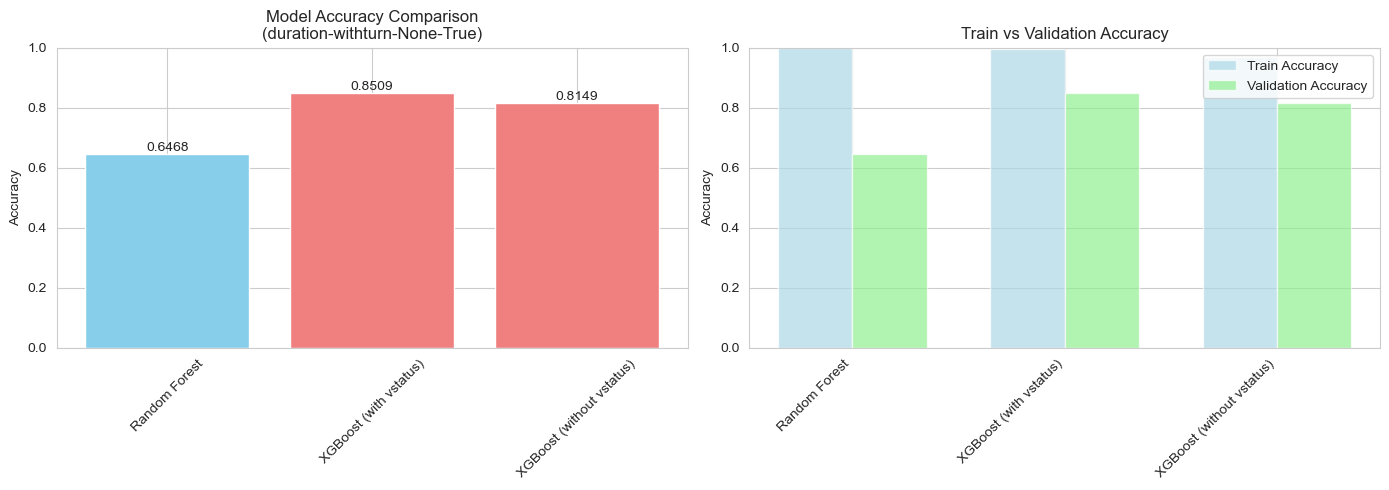


HYPERPARAMETERS COMPARISON

Random Forest Parameters:
  n_estimators: 100
  max_depth: None
  min_samples_split: 2
  min_samples_leaf: 1

XGBoost Parameters (with victory_status):
  n_estimators: 350
  max_depth: 8
  learning_rate: 0.17525298397474734

XGBoost Parameters (without victory_status):
  n_estimators: 550
  max_depth: 4
  learning_rate: 0.29091447472329546


In [46]:
# Visual comparison
if len(df_comparison) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Bar plot comparing accuracies
    models_labels = []
    accuracies = []
    colors = []
    
    for _, row in df_comparison.iterrows():
        label = f"{row['Model']}"
        if row['Model'] == 'XGBoost':
            label += f" ({'with' if row['Has Victory Status'] else 'without'} vstatus)"
        models_labels.append(label)
        accuracies.append(row['Accuracy'])
        colors.append('skyblue' if row['Model'] == 'Random Forest' else 'lightcoral')
    
    bars = axes[0].bar(models_labels, accuracies, color=colors)
    axes[0].set_title('Model Accuracy Comparison\n(duration-withturn-None-True)')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_ylim([0, 1.0])
    axes[0].tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar, acc in zip(bars, accuracies):
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{acc:.4f}',
                    ha='center', va='bottom')
    
    # Train vs Validation accuracy comparison
    if 'Train Accuracy' in df_comparison.columns:
        x_pos = np.arange(len(models_labels))
        width = 0.35
        
        train_accs = df_comparison['Train Accuracy'].values
        valid_accs = df_comparison['Accuracy'].values
        
        axes[1].bar(x_pos - width/2, train_accs, width, label='Train Accuracy', color='lightblue', alpha=0.7)
        axes[1].bar(x_pos + width/2, valid_accs, width, label='Validation Accuracy', color='lightgreen', alpha=0.7)
        
        axes[1].set_title('Train vs Validation Accuracy')
        axes[1].set_ylabel('Accuracy')
        axes[1].set_xticks(x_pos)
        axes[1].set_xticklabels(models_labels, rotation=45, ha='right')
        axes[1].legend()
        axes[1].set_ylim([0, 1.0])
    
    plt.tight_layout()
    plt.show()
    
    # Print hyperparameters comparison
    print("\n" + "=" * 80)
    print("HYPERPARAMETERS COMPARISON")
    print("=" * 80)
    
    if 'RF_with_vstatus' in rf_results and 'params' in rf_results['RF_with_vstatus']:
        print("\nRandom Forest Parameters:")
        for key, value in rf_results['RF_with_vstatus']['params'].items():
            print(f"  {key}: {value}")
    
    if 'XGB_with_vstatus' in xgb_results and 'params' in xgb_results['XGB_with_vstatus']:
        print("\nXGBoost Parameters (with victory_status):")
        for key, value in xgb_results['XGB_with_vstatus']['params'].items():
            print(f"  {key}: {value}")
    
    if 'XGB_without_vstatus' in xgb_results and 'params' in xgb_results['XGB_without_vstatus']:
        print("\nXGBoost Parameters (without victory_status):")
        for key, value in xgb_results['XGB_without_vstatus']['params'].items():
            print(f"  {key}: {value}")


XGBoost outperforms Random Forest. However the comparison is somewhat unfair because:
- XGBoost was optimized; Random Forest was not.
- Random Forest could improve with tuning (e.g., more trees, tuned max_depth, min_samples_split), though it likely still wouldn’t match XGBoost.

The results show that XGBoost with optimized hyperparameters significantly outperforms an untuned Random Forest baseline for this task.

While we didn’t have time to optimize Random Forest hyperparameters, the random Forest serves as a baseline that any optimized model (like XGBoost) should exceed.

This baseline helps us to set a minimum performance target and measure improvement from optimization

## Hyperparameter Analysis

We will now analysis how often each hyperparameter value appears and the relationships between hyperparameters and accuracy.

We do this to find which ranges were the best for our models and detect interactions: does learning_rate work better with certain max_depth?

This will allow us to guide our future tuning ann focus our search on promising regions

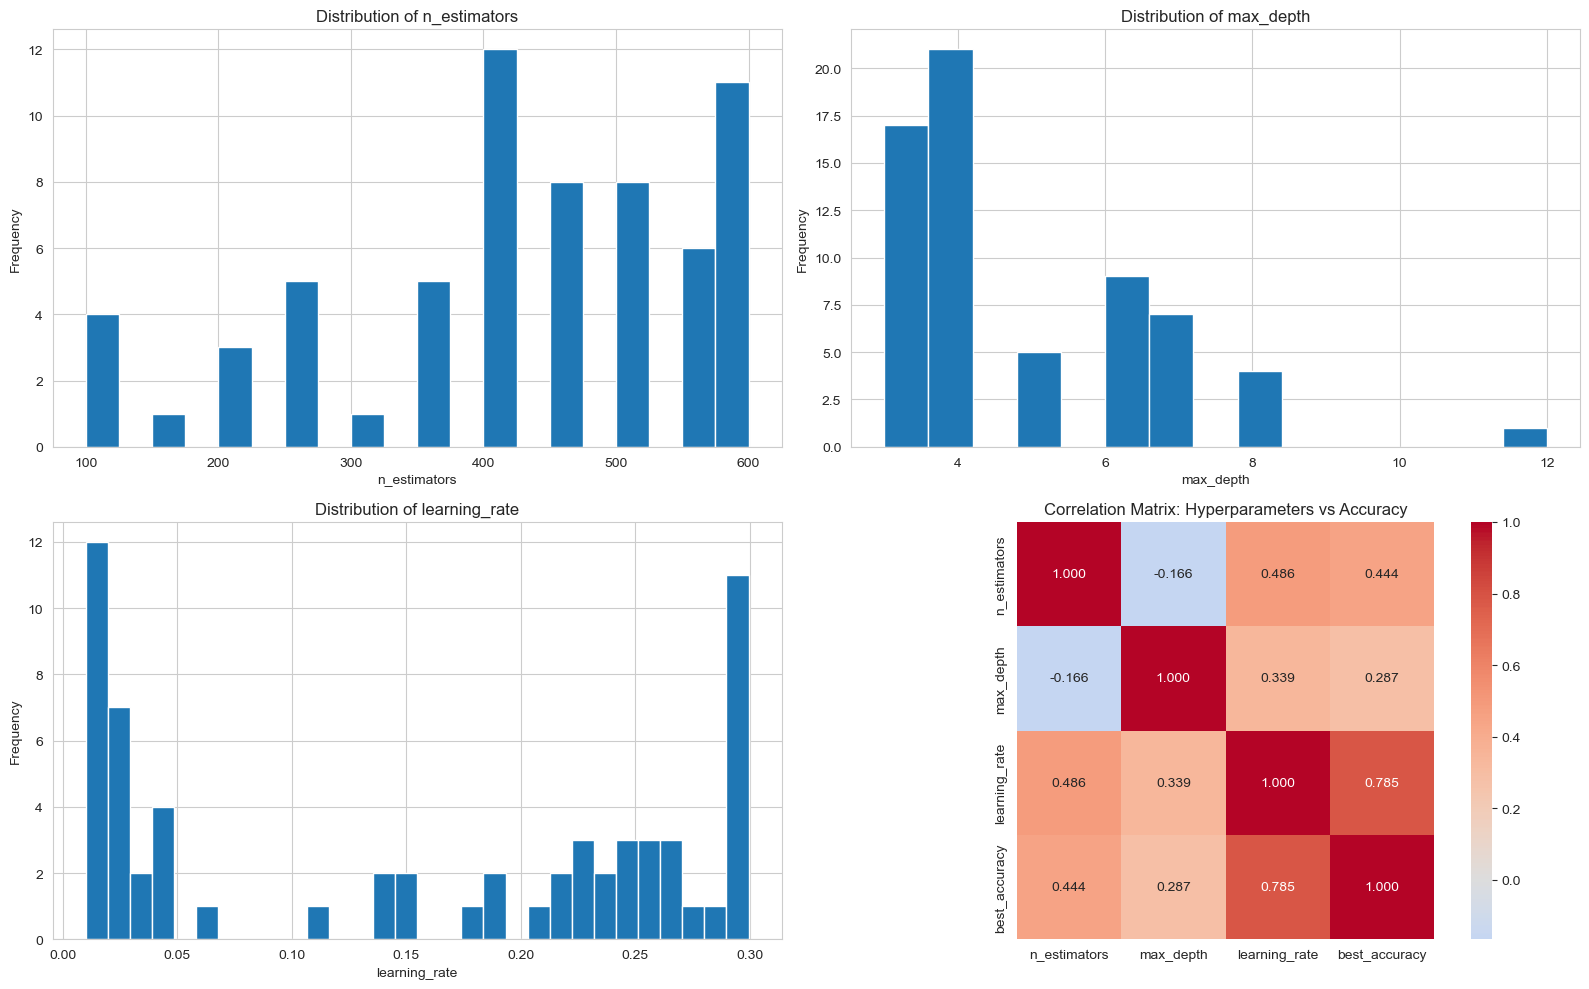


Hyperparameter Statistics:
       n_estimators  max_depth  learning_rate
count     64.000000  64.000000      64.000000
mean     417.968750   4.796875       0.152445
std      145.396881   1.818596       0.114686
min      100.000000   3.000000       0.010207
25%      350.000000   3.000000       0.024385
50%      450.000000   4.000000       0.182028
75%      550.000000   6.000000       0.259655
max      600.000000  12.000000       0.299421


In [31]:
# Analyze hyperparameters
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Distribution of hyperparameters
df_results['n_estimators'].hist(bins=20, ax=axes[0, 0])
axes[0, 0].set_title('Distribution of n_estimators')
axes[0, 0].set_xlabel('n_estimators')
axes[0, 0].set_ylabel('Frequency')

df_results['max_depth'].hist(bins=15, ax=axes[0, 1])
axes[0, 1].set_title('Distribution of max_depth')
axes[0, 1].set_xlabel('max_depth')
axes[0, 1].set_ylabel('Frequency')

df_results['learning_rate'].hist(bins=30, ax=axes[1, 0])
axes[1, 0].set_title('Distribution of learning_rate')
axes[1, 0].set_xlabel('learning_rate')
axes[1, 0].set_ylabel('Frequency')

# Correlation between hyperparameters and performance
corr_data = df_results[['n_estimators', 'max_depth', 'learning_rate', 'best_accuracy']].corr()
sns.heatmap(corr_data, annot=True, fmt='.3f', cmap='coolwarm', center=0, ax=axes[1, 1], square=True)
axes[1, 1].set_title('Correlation Matrix: Hyperparameters vs Accuracy')

plt.tight_layout()
plt.show()

print("=" * 80)
print("Hyperparameter Statistics:")
print("=" * 80)
print(df_results[['n_estimators', 'max_depth', 'learning_rate']].describe())


HYPERPARAMETER PATTERNS FOR TOP 20 MODELS

Top 20 models - Hyperparameter statistics:
n_estimators - Mean: 485.0, Median: 500.0
max_depth - Mean: 5.25, Median: 5.5
learning_rate - Mean: 0.2448, Median: 0.2508


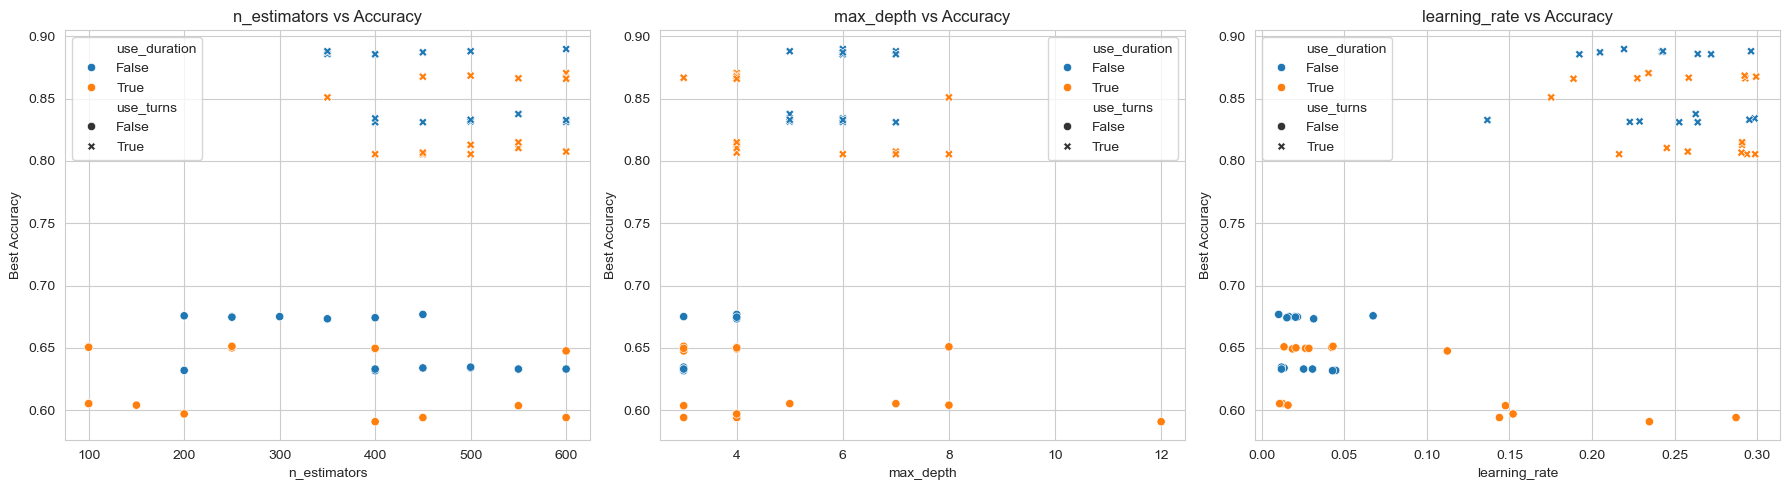

In [32]:
# Analyze hyperparameter patterns for best models
print("=" * 80)
print("HYPERPARAMETER PATTERNS FOR TOP 20 MODELS")
print("=" * 80)

top_20 = df_results.nlargest(20, 'best_accuracy')
print(f"\nTop 20 models - Hyperparameter statistics:")
print(f"n_estimators - Mean: {top_20['n_estimators'].mean():.1f}, Median: {top_20['n_estimators'].median():.1f}")
print(f"max_depth - Mean: {top_20['max_depth'].mean():.2f}, Median: {top_20['max_depth'].median():.1f}")
print(f"learning_rate - Mean: {top_20['learning_rate'].mean():.4f}, Median: {top_20['learning_rate'].median():.4f}")

# Scatter plots showing relationship between hyperparameters and performance
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.scatterplot(data=df_results, x='n_estimators', y='best_accuracy', hue='use_duration', style='use_turns', ax=axes[0])
axes[0].set_title('n_estimators vs Accuracy')
axes[0].set_xlabel('n_estimators')
axes[0].set_ylabel('Best Accuracy')

sns.scatterplot(data=df_results, x='max_depth', y='best_accuracy', hue='use_duration', style='use_turns', ax=axes[1])
axes[1].set_title('max_depth vs Accuracy')
axes[1].set_xlabel('max_depth')
axes[1].set_ylabel('Best Accuracy')

sns.scatterplot(data=df_results, x='learning_rate', y='best_accuracy', hue='use_duration', style='use_turns', ax=axes[2])
axes[2].set_title('learning_rate vs Accuracy')
axes[2].set_xlabel('learning_rate')
axes[2].set_ylabel('Best Accuracy')

plt.tight_layout()
plt.show()


## Detailed Comparison Tables


In [35]:
print("=" * 80)
print("BEST MODEL FOR EACH FEATURE COMBINATION")
print("=" * 80)

# Group by feature combinations and get best model for each
feature_cols = ['has_victory_status', 'use_duration', 'use_turns']
best_by_combo = df_results.loc[df_results.groupby(feature_cols)['best_accuracy'].idxmax()]

display_cols = ['has_victory_status', 'use_duration', 'use_turns', 'moves_n', 
                'best_accuracy', 'n_estimators', 'max_depth', 'learning_rate']
print(best_by_combo[display_cols].to_string(index=False))


BEST MODEL FOR EACH FEATURE COMBINATION
 has_victory_status  use_duration  use_turns  moves_n  best_accuracy  n_estimators  max_depth  learning_rate
              False         False      False      1.0       0.634632           500          3       0.011884
              False         False       True      2.0       0.837566           550          5       0.262820
              False          True      False      2.0       0.605383           100          7       0.012578
              False          True       True      NaN       0.814907           550          4       0.290914
               True         False      False      7.0       0.676883           450          4       0.010207
               True         False       True      NaN       0.889667           600          6       0.219410
               True          True      False      NaN       0.651346           250          3       0.043109
               True          True       True      2.0       0.870393           600      

In [36]:
# Summary statistics by feature combinations
print("\n" + "=" * 80)
print("SUMMARY STATISTICS BY FEATURE COMBINATIONS")
print("=" * 80)

summary_stats = df_results.groupby(feature_cols).agg({
    'best_accuracy': ['mean', 'std', 'min', 'max', 'count']
}).round(4)

print(summary_stats)



SUMMARY STATISTICS BY FEATURE COMBINATIONS
                                          best_accuracy                  \
                                                   mean     std     min   
has_victory_status use_duration use_turns                                 
False              False        False            0.6332  0.0010  0.6318   
                                True             0.8328  0.0022  0.8310   
                   True         False            0.5994  0.0059  0.5909   
                                True             0.8085  0.0037  0.8054   
True               False        False            0.6750  0.0010  0.6734   
                                True             0.8871  0.0015  0.8855   
                   True         False            0.6499  0.0012  0.6476   
                                True             0.8653  0.0060  0.8509   

                                                         
                                              max count  
has_victory_st

## Key Findings and Recommendations


In [37]:
print("=" * 80)
print("KEY FINDINGS")
print("=" * 80)

# Best overall model
best_model = df_results.loc[df_results['best_accuracy'].idxmax()]
print(f"\n1. BEST OVERALL MODEL:")
print(f"   Accuracy: {best_model['best_accuracy']:.4f}")
print(f"   Configuration: Victory Status={best_model['has_victory_status']}, "
      f"Duration={best_model['use_duration']}, Turns={best_model['use_turns']}, "
      f"Moves={best_model['moves_n']}")
print(f"   Hyperparameters: n_estimators={best_model['n_estimators']}, "
      f"max_depth={best_model['max_depth']}, learning_rate={best_model['learning_rate']:.4f}")

# Impact of victory_status
vstatus_impact = df_results.groupby('has_victory_status')['best_accuracy'].mean()
print(f"\n2. IMPACT OF VICTORY STATUS:")
print(f"   With Victory Status: {vstatus_impact[True]:.4f} (mean accuracy)")
print(f"   Without Victory Status: {vstatus_impact[False]:.4f} (mean accuracy)")
print(f"   Difference: {vstatus_impact[True] - vstatus_impact[False]:.4f}")

# Impact of duration
duration_impact = df_results.groupby('use_duration')['best_accuracy'].mean()
print(f"\n3. IMPACT OF DURATION:")
print(f"   With Duration: {duration_impact[True]:.4f} (mean accuracy)")
print(f"   Without Duration: {duration_impact[False]:.4f} (mean accuracy)")
print(f"   Difference: {duration_impact[False] - duration_impact[True]:.4f}")

# Impact of turns
turns_impact = df_results.groupby('use_turns')['best_accuracy'].mean()
print(f"\n4. IMPACT OF TURNS:")
print(f"   With Turns: {turns_impact[True]:.4f} (mean accuracy)")
print(f"   Without Turns: {turns_impact[False]:.4f} (mean accuracy)")
print(f"   Difference: {turns_impact[True] - turns_impact[False]:.4f}")

# Best number of moves
if df_results['moves_n'].notna().any():
    moves_impact = df_results[df_results['moves_n'].notna()].groupby('moves_n')['best_accuracy'].mean()
    best_moves = moves_impact.idxmax()
    print(f"\n5. BEST NUMBER OF MOVES:")
    print(f"   Best moves_n: {best_moves} (mean accuracy: {moves_impact[best_moves]:.4f})")

# Hyperparameter insights
print(f"\n6. HYPERPARAMETER INSIGHTS:")
top_10 = df_results.nlargest(10, 'best_accuracy')
print(f"   Top 10 models average n_estimators: {top_10['n_estimators'].mean():.1f}")
print(f"   Top 10 models average max_depth: {top_10['max_depth'].mean():.2f}")
print(f"   Top 10 models average learning_rate: {top_10['learning_rate'].mean():.4f}")

print("\n" + "=" * 80)


KEY FINDINGS

1. BEST OVERALL MODEL:
   Accuracy: 0.8897
   Configuration: Victory Status=True, Duration=False, Turns=True, Moves=nan
   Hyperparameters: n_estimators=600, max_depth=6, learning_rate=0.2194

2. IMPACT OF VICTORY STATUS:
   With Victory Status: 0.7693 (mean accuracy)
   Without Victory Status: 0.7185 (mean accuracy)
   Difference: 0.0508

3. IMPACT OF DURATION:
   With Duration: 0.7308 (mean accuracy)
   Without Duration: 0.7570 (mean accuracy)
   Difference: 0.0263

4. IMPACT OF TURNS:
   With Turns: 0.8484 (mean accuracy)
   Without Turns: 0.6394 (mean accuracy)
   Difference: 0.2090

5. BEST NUMBER OF MOVES:
   Best moves_n: 2.0 (mean accuracy: 0.7462)

6. HYPERPARAMETER INSIGHTS:
   Top 10 models average n_estimators: 450.0
   Top 10 models average max_depth: 5.70
   Top 10 models average learning_rate: 0.2461



## Export Results Summary


In [38]:
# Export summary to CSV for easy sharing
output_file = RESULTS_DIR / "analysis_summary.csv"
df_results.to_csv(output_file, index=False)
print(f"Results exported to: {output_file}")

# Create a simplified summary table
summary_table = df_results[[
    'has_victory_status', 'use_duration', 'use_turns', 'moves_n',
    'best_accuracy', 'n_estimators', 'max_depth', 'learning_rate'
]].round(4)

print("\nSummary table (first 20 rows):")
print(summary_table.head(20).to_string(index=False))


Results exported to: results\analysis_summary.csv

Summary table (first 20 rows):
 has_victory_status  use_duration  use_turns  moves_n  best_accuracy  n_estimators  max_depth  learning_rate
               True          True       True      NaN         0.8509           350          8         0.1753
               True          True      False      2.0         0.6509           100          8         0.0134
               True          True      False      3.0         0.6505           100          4         0.0423
               True          True      False      4.0         0.6497           400          3         0.0265
               True          True      False      5.0         0.6493           400          4         0.0185
               True          True      False      6.0         0.6501           250          4         0.0207
               True          True      False      7.0         0.6476           600          3         0.1124
               True          True      False  